Load & Clean Human Big Five Data

In [24]:
#Import Dependencies
import pandas as pd
import numpy as np
import os
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load Big Five dataset (tab-delimited)
file_path = os.path.join("..", "data", "raw", "big_five.csv")
df_people = pd.read_csv(file_path, delimiter="\t")

# Define column groups for Big Five traits
ext_cols = [f'EXT{i}' for i in range(1, 11)]  # Extraversion
est_cols = [f'EST{i}' for i in range(1, 11)]  # Neuroticism
agr_cols = [f'AGR{i}' for i in range(1, 11)]  # Agreeableness
csn_cols = [f'CSN{i}' for i in range(1, 11)]  # Conscientiousness
opn_cols = [f'OPN{i}' for i in range(1, 11)]  # Openness

# Filter and clean numeric Big Five answers
df_traits = df_people[ext_cols + est_cols + agr_cols + csn_cols + opn_cols].dropna()
df_traits = df_traits.apply(pd.to_numeric)

# Calculate average scores for each trait
df_traits['E'] = df_traits[ext_cols].mean(axis=1)
df_traits['N'] = df_traits[est_cols].mean(axis=1)
df_traits['A'] = df_traits[agr_cols].mean(axis=1)
df_traits['C'] = df_traits[csn_cols].mean(axis=1)
df_traits['O'] = df_traits[opn_cols].mean(axis=1)

# Final cleaned DataFrame of OCEAN scores
df_ocean = df_traits[['O', 'C', 'E', 'A', 'N']].copy()
print("Cleaned OCEAN scores:")
display(df_ocean.head())


Cleaned OCEAN scores:


,O,C,E,A,N
0,3.3,3.2,3.0,3.1,2.4
1,2.7,3.1,3.4,3.2,2.1
2,3.1,2.8,2.9,2.8,2.6
3,3.1,2.7,2.6,3.2,2.7
4,3.6,3.2,3.5,3.0,2.3


Generate and Save Synthetic Dog Type Training Data

In [25]:
# Load dog type trait centers
traits_path = os.path.join("..", "data", "processed", "dog_type_traits.csv")
df_base = pd.read_csv(traits_path)

# Parameters for synthetic data generation
np.random.seed(42)
samples_per_type = 200
noise_std = 1.0

# Create synthetic rows per dog_type
expanded_rows = []
for _, row in df_base.iterrows():
    for _ in range(samples_per_type):
        expanded_rows.append({
            'dog_type': row['dog_type'],
            'O': np.clip(np.random.normal(row['O'], noise_std), 1, 5),
            'C': np.clip(np.random.normal(row['C'], noise_std), 1, 5),
            'E': np.clip(np.random.normal(row['E'], noise_std), 1, 5),
            'A': np.clip(np.random.normal(row['A'], noise_std), 1, 5),
            'N': np.clip(np.random.normal(row['N'], noise_std), 1, 5)
        })

df_expanded = pd.DataFrame(expanded_rows)

# Save to SQLite database
conn = sqlite3.connect("../data/processed/dog_personality.db")
df_expanded.to_sql("dog_traits", conn, if_exists="replace", index=False)
conn.close()
print("Synthetic training data saved to SQLite.")


Synthetic training data saved to SQLite.


Visualize Training Data with PCA and KMeans Plots

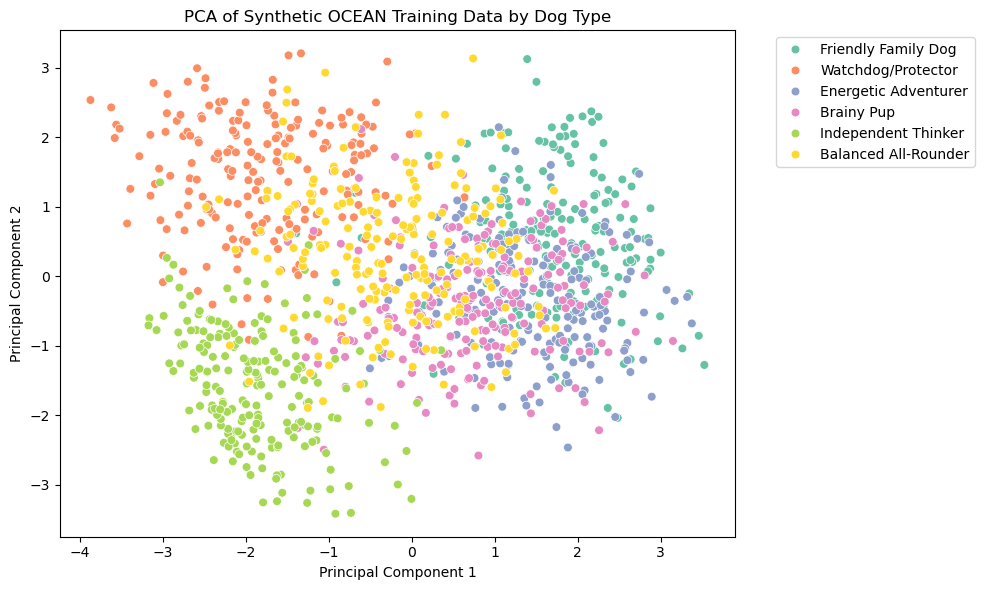

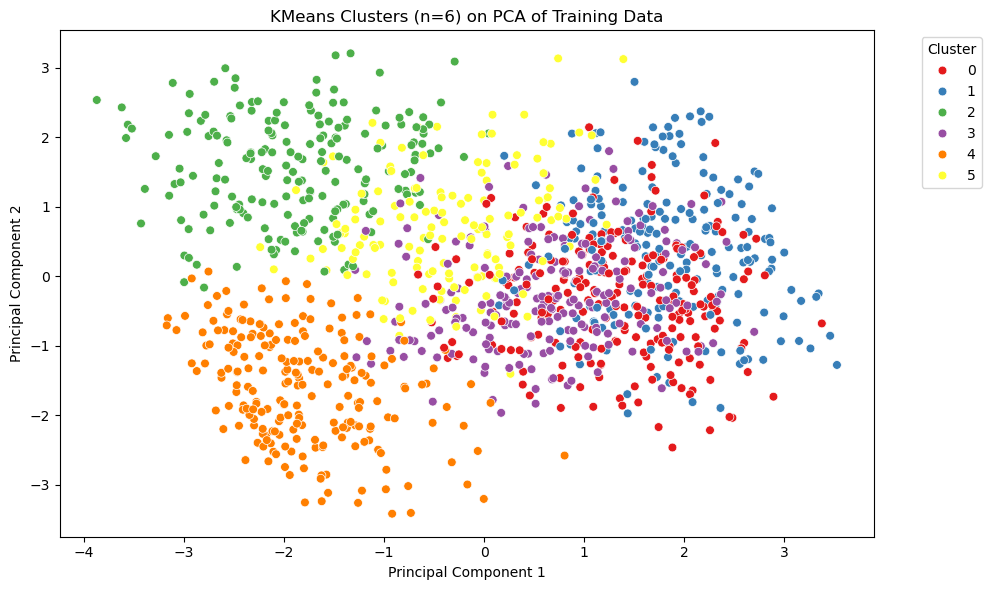

In [27]:
# Using numeric OCEAN columns for PCA & clustering
X = df_expanded[['O', 'C', 'E', 'A', 'N']]
y = df_expanded['dog_type']

# PCA 2D Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["dog_type"] = y.values

# Plotting PCA by dog_type
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="dog_type", palette="Set2", s=40)
plt.title("PCA of Synthetic OCEAN Training Data by Dog Type")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../visuals/pca_dog_type_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

# KMeans Clustering
kmeans = KMeans(n_clusters=6, random_state=42)
df_pca["kmeans_cluster"] = kmeans.fit_predict(X)

# Plotting PCA colored by KMeans cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="kmeans_cluster", palette="Set1", s=40)
plt.title("KMeans Clusters (n=6) on PCA of Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../visuals/pca_kmeans_clusters.png", dpi=300, bbox_inches='tight')
plt.show()




Overlay Real People on PCA Plot

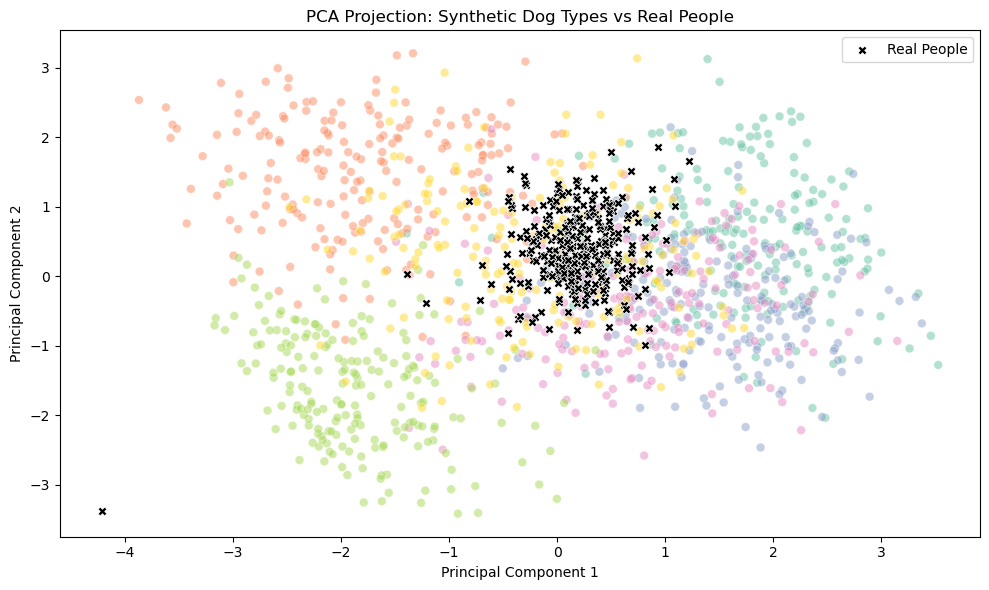

In [28]:
# Sampling real users for visualization
df_people_sample = df_ocean[['O', 'C', 'E', 'A', 'N']].sample(n=300, random_state=42)
X_people_pca = pca.transform(df_people_sample)

df_overlay = pd.DataFrame(X_people_pca, columns=["PC1", "PC2"])
df_overlay["source"] = "Real People"

# Adding synthetic data back in for comparison
df_training = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_training["source"] = "Training Data"
df_training["dog_type"] = y.values

# Combining both datasets
df_combined = pd.concat([df_training, df_overlay], ignore_index=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_combined[df_combined['source'] == "Training Data"],
    x="PC1", y="PC2", hue="dog_type",
    alpha=0.5, s=40, palette="Set2", legend=False
)
sns.scatterplot(
    data=df_combined[df_combined['source'] == "Real People"],
    x="PC1", y="PC2", color="black",
    label="Real People", s=40, marker="X"
)
plt.title("PCA Projection: Synthetic Dog Types vs Real People")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.savefig("../visuals/pca_overlay_real_people.png", dpi=300, bbox_inches='tight')
plt.show()


In [29]:
# Checking how much each trait contributes to PC1 and PC2
pca_components = pd.DataFrame(
    pca.components_,
    columns=['O', 'C', 'E', 'A', 'N'],
    index=['PC1', 'PC2']
)
display(pca_components.T)

,PC1,PC2
O,0.375429,-0.428000
C,-0.061843,0.582886
E,0.674942,0.182450
A,0.600058,0.316972
N,-0.199027,0.585919


Load Training Data from SQLite

In [30]:
conn = sqlite3.connect("../data/processed/dog_personality.db")
df_expanded_sql = pd.read_sql("SELECT * FROM dog_traits", conn)
conn.close()
print("Reloaded training data from SQLite:", df_expanded_sql.shape)

Reloaded training data from SQLite: (1200, 6)


Train and Run Models

In [31]:
# Use SQL-loaded data for training
X_train = df_expanded_sql[['O', 'C', 'E', 'A', 'N']]
y_train = df_expanded_sql['dog_type']

# Use cleaned Big Five scores for test predictions
X_test = df_ocean[['O', 'C', 'E', 'A', 'N']]

# Train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
df_ocean['predicted_dog_type_knn'] = knn.predict(X_test)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
df_ocean['logreg_prediction'] = log_reg.predict(X_test)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
df_ocean['rf_prediction'] = rf.predict(X_test)

Show Sample Predictions

In [32]:

# Sample predictions from each model
print("\nSample predictions from all models:")
display(df_ocean[['O', 'C', 'E', 'A', 'N', 'predicted_dog_type_knn', 'logreg_prediction', 'rf_prediction']].head())

# Prediction distribution by model
print("\nKNN Prediction Distribution:")
print(df_ocean['predicted_dog_type_knn'].value_counts())

print("\nLogistic Regression Prediction Distribution:")
print(df_ocean['logreg_prediction'].value_counts())

print("\nRandom Forest Prediction Distribution:")
print(df_ocean['rf_prediction'].value_counts())


Sample predictions from all models:


,O,C,E,A,N,predicted_dog_type_knn,logreg_prediction,rf_prediction
0,3.3,3.2,3.0,3.1,2.4,Balanced All-Rounder,Balanced All-Rounder,Balanced All-Rounder
1,2.7,3.1,3.4,3.2,2.1,Balanced All-Rounder,Balanced All-Rounder,Balanced All-Rounder
2,3.1,2.8,2.9,2.8,2.6,Balanced All-Rounder,Balanced All-Rounder,Balanced All-Rounder
3,3.1,2.7,2.6,3.2,2.7,Balanced All-Rounder,Balanced All-Rounder,Balanced All-Rounder
4,3.6,3.2,3.5,3.0,2.3,Balanced All-Rounder,Balanced All-Rounder,Balanced All-Rounder



KNN Prediction Distribution:
predicted_dog_type_knn
Balanced All-Rounder    819638
Brainy Pup              100836
Energetic Adventurer     62618
Watchdog/Protector       21701
Independent Thinker       5795
Friendly Family Dog       2970
Name: count, dtype: int64

Logistic Regression Prediction Distribution:
logreg_prediction
Balanced All-Rounder    964778
Brainy Pup               28303
Friendly Family Dog       9664
Independent Thinker       5627
Watchdog/Protector        3212
Energetic Adventurer      1974
Name: count, dtype: int64

Random Forest Prediction Distribution:
rf_prediction
Balanced All-Rounder    898422
Brainy Pup               53142
Watchdog/Protector       39923
Energetic Adventurer      8904
Friendly Family Dog       7044
Independent Thinker       6123
Name: count, dtype: int64


Evaluate Model Accuracy

In [33]:
# Train/test split from SQL-loaded synthetic training data
X = df_expanded_sql[['O', 'C', 'E', 'A', 'N']]
y = df_expanded_sql['dog_type']
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Refit and evaluate all 3 models
knn.fit(X_train_sub, y_train_sub)
knn_acc = accuracy_score(y_val, knn.predict(X_val))

log_reg.fit(X_train_sub, y_train_sub)
logreg_acc = accuracy_score(y_val, log_reg.predict(X_val))

rf.fit(X_train_sub, y_train_sub)
rf_acc = accuracy_score(y_val, rf.predict(X_val))

# Display validation results
print("\nValidation Accuracy Results:")
print(f"Validation Accuracy (KNN): {knn_acc:.2%}")
print(f"Validation Accuracy (Logistic Regression): {logreg_acc:.2%}")
print(f"Validation Accuracy (Random Forest): {rf_acc:.2%}")


Validation Accuracy Results:
Validation Accuracy (KNN): 75.83%
Validation Accuracy (Logistic Regression): 80.83%
Validation Accuracy (Random Forest): 75.42%


Document Model Evaluation Summary

In [34]:
# Create a summary DataFrame
model_results = pd.DataFrame({
    'Model': ['KNN (k=3)', 'Logistic Regression', 'Random Forest'],
    'Validation Accuracy': [knn_acc, logreg_acc, rf_acc]
})

print("\nModel Evaluation Summary:")
display(model_results)



Model Evaluation Summary:


,Model,Validation Accuracy
0,KNN (k=3),0.758333
1,Logistic Regression,0.808333
2,Random Forest,0.754167


## Model Optimization Summary

To identify the best model for predicting dog personality types based on OCEAN scores, I created multiple versions using different training setups and algorithms. Evaluation was done on a validation set (20% split) from a synthetic dataset (200 samples per dog type, noise = 0.6).

| Version | Description                           | Model Type              | Accuracy   | Notes                                                                 |
|---------|----------------------------------------|--------------------------|------------|-----------------------------------------------------------------------|
| V1      | One training sample per dog type       | KNeighborsClassifier     | N/A        | Too little data; model overfit or failed to generalize                |
| V2      | Same data, tuned k=1                   | KNeighborsClassifier     | N/A        | Slightly improved, but still unstable                                |
| V3      | Synthetic training (20/type)           | KNeighborsClassifier     | N/A        | Early working version for distribution checks only                   |
| V4      | Same data                              | LogisticRegression       | N/A        | Showed improved prediction variety                                   |
| V5      | Same data                              | RandomForestClassifier   | N/A        | Stronger distribution learning; no formal eval yet                   |
| V6      | Eval on expanded 200/type, noise=0.6   | KNeighborsClassifier     | 75.83%     | Met threshold; moderate generalization                     |
| V7      | Same training/eval set                 | LogisticRegression       | **80.83%** | Highest accuracy; selected as final model                          |
| V8      | Same training/eval set                 | RandomForestClassifier   | 75.42%     | Valid alternative; slightly underperforms logistic regression        |

> Final Model Selected: **Logistic Regression**
> - Best validation accuracy (80.83%)
> - Interpretable and consistent
> - Good performance across personality clusters


Match Predicted Dog Types to Breeds

In [35]:
# Reconnect to the SQLite database
conn = sqlite3.connect(os.path.join("..", "data", "processed", "dog_personality.db"))
df_breeds = pd.read_sql("SELECT * FROM akc_breeds", conn)
conn.close()

# Build dictionary: dog_type -> 3 random breed samples
breed_lookup = (
    df_breeds.groupby("dog_type")["Breed"]
    .apply(lambda x: x.sample(n=min(3, len(x)), random_state=42).tolist())
    .to_dict()
)

# Map predictions to breed recommendations
df_ocean['recommended_breeds'] = df_ocean['logreg_prediction'].map(breed_lookup)

# Show a sample
print("Sample personality-based dog breed recommendations:")
display(df_ocean[['O', 'C', 'E', 'A', 'N', 'logreg_prediction', 'recommended_breeds']].head())


Sample personality-based dog breed recommendations:


,O,C,E,A,N,logreg_prediction,recommended_breeds
0,3.3,3.2,3.0,3.1,2.4,Balanced All-Rounder,"[Sloughis, Skye Terriers, Shiba Inu]"
1,2.7,3.1,3.4,3.2,2.1,Balanced All-Rounder,"[Sloughis, Skye Terriers, Shiba Inu]"
2,3.1,2.8,2.9,2.8,2.6,Balanced All-Rounder,"[Sloughis, Skye Terriers, Shiba Inu]"
3,3.1,2.7,2.6,3.2,2.7,Balanced All-Rounder,"[Sloughis, Skye Terriers, Shiba Inu]"
4,3.6,3.2,3.5,3.0,2.3,Balanced All-Rounder,"[Sloughis, Skye Terriers, Shiba Inu]"


User Input for Personality-Based Dog Match

In [36]:
#Predict Dog Type from User Input
def predict_dog_type_from_input():
    print("🐾 Enter your Big Five personality scores (1–5):")
    try:
        o = float(input("Please Input Your Personality Score (1-5) for Openness (O): "))
        c = float(input("Please Input Your Personality Score (1-5) for Conscientiousness (C): "))
        e = float(input("Please Input Your Personality Score (1-5) for Extraversion (E): "))
        a = float(input("Please Input Your Personality Score (1-5) for Agreeableness (A): "))
        n = float(input("Please Input Your Personality Score (1-5) Neuroticism (N): "))

        # Validate input range
        for score in [o, c, e, a, n]:
            if score < 1 or score > 5:
                print("❗ Scores must be between 1 and 5.")
                return

        # Make a prediction
        user_df = pd.DataFrame([[o, c, e, a, n]], columns=['O', 'C', 'E', 'A', 'N'])
        predicted_type = log_reg.predict(user_df)[0]
        recommended_breeds = breed_lookup.get(predicted_type, [])

           # Show result
        print(f"\n🎯 Your dog personality type is: **{predicted_type}**")
        if recommended_breeds:
            print("🐶 Based on your personality, you're most like one of these dog breeds:")
            for breed in recommended_breeds:
                print(f"  • {breed}")
        else:
            print("Hmm, we couldn't find matching breeds — you're a rare pup!")

    except ValueError:
        print("Invalid input. Please enter numbers between 1 and 5.")

# Run the function
predict_dog_type_from_input()

🐾 Enter your Big Five personality scores (1–5):

🎯 Your dog personality type is: **Energetic Adventurer**
🐶 Based on your personality, you're most like one of these dog breeds:
  • Beagles
  • Pointers (German Wirehaired)
  • Parson Russell Terriers
